In [1]:
import asyncio
import datetime
import subprocess


In [4]:

async def runcmd(cmd, verbose=True):
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        shell=True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    return std_out.strip()

In [13]:

async def download_data():
    today = datetime.date.today().strftime("%Y-%m-%d")
    yesterday = (datetime.date.today() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    past_date = datetime.date.today() - datetime.timedelta(days=2)
    
    while True:
        # Check if today's file is empty
        df_data = await runcmd(f'cat {today} || wget --no-check-certificate https://www.nepalstock.com.np/api/nots/market/export/todays-price/{today}', verbose=False)
        print(today)
        if df_data.strip() == '':
            # Today's file is empty, let's try yesterday
            df_data = await runcmd(f'cat {yesterday} || wget --no-check-certificate https://www.nepalstock.com.np/api/nots/market/export/todays-price/{yesterday}', verbose=False)
            print(yesterday)
            if df_data.strip() == '':
                # Yesterday's file is also empty, fetch past day's data
                past_date_str = past_date.strftime("%Y-%m-%d")
                df_data = await runcmd(f'cat {past_date_str} || wget --no-check-certificate https://www.nepalstock.com.np/api/nots/market/export/todays-price/{past_date_str}', verbose=False)
                # Update past_date for next iteration
                past_date -= datetime.timedelta(days=1)
                print(past_date)
                # Sleep for some time to avoid flooding requests
                await asyncio.sleep(5)  # Adjust sleep time as needed
            else:
                break  # Exit loop if yesterday's data is found
        else:
            break  # Exit loop if today's data is found
    return df_data

In [14]:
async def main():
    await download_data()

In [15]:
# Example usage
asyncio.run(main())

In [11]:
import os
import shlex
url = 'https://www.nepalstock.com.np/api/nots/market/export/todays-price/2024-03-26'
data = os.system(f"wget --no-check-certificate {shlex.quote(url)}")
data

--2024-03-26 18:10:27--  https://www.nepalstock.com.np/api/nots/market/export/todays-price/2024-03-26
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.nepalstock.com.np (www.nepalstock.com.np)... 182.93.68.4
Connecting to www.nepalstock.com.np (www.nepalstock.com.np)|182.93.68.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘2024-03-26.1’

     0K .......... .......... .......... .......... .......... 6.82M
    50K ........                                               15.7T=0.007s

2024-03-26 18:10:27 (7.97 MB/s) - ‘2024-03-26.1’ saved [59852]



0

In [24]:
df.columns

Index(['S.No', 'Symbol', 'Conf.', 'Open', 'High', 'Low', 'Close', 'VWAP',
       'Vol', 'Prev. Close', 'Turnover', 'Trans.', 'Diff', 'Range', 'Diff %',
       'Range %', 'VWAP %', '120 Days', '180 Days', '52 Weeks High',
       '52 Weeks Low'],
      dtype='object')

In [21]:
import urllib.request
import ssl

# Disable SSL certificate verification
ssl_context = ssl.create_default_context()
ssl_context.check_hostname = False
ssl_context.verify_mode = ssl.CERT_NONE

url = "https://www.nepalstock.com.np/api/nots/market/export/todays-price/2024-03-26"

try:
    # Open the URL and retrieve the data
    with urllib.request.urlopen(url, context=ssl_context) as response:
        # Read the data from the response
        data = response.read()
        
        # Save the data to a file
        with open("todays_price_2024-03-26.csv", "wb") as file:
            file.write(data)
            
    print("File downloaded successfully.")
    
except Exception as e:
    print("Error:", e)


Error: Remote end closed connection without response


In [37]:
import requests
import pandas as pd

def get_stock_details(stock_name):
    
    json_out = requests.get(f'https://the-value-crew.github.io/nepse-api/data/company/{stock_name}.json')
    
    json_out = json_out.json()
    
    # Convert JSON data into a DataFrame
    df = pd.DataFrame(json_out).T

    # Convert the nested 'price' dictionaries into separate columns
    price_df = df['price'].apply(pd.Series)

    # Concatenate the original DataFrame with the new 'price' DataFrame
    df = pd.concat([df.drop('price', axis=1), price_df], axis=1)
    
    # first column name is the date
    df.index.name = 'Date'
    
    return df

In [43]:
df.head()

,numTrans,tradedShares,amount,max,min,close,prevClose,diff,open
Date,,,,,,,,,
2022-02-20,478,35466,14177046.7,402.0,395.0,399.0,405.0,-6.0,NaN
2022-02-21,322,27798,11132799.4,405.0,398.0,402.0,399.0,3.0,NaN
2022-02-23,363,35048,14076613.9,406.0,399.9,400.0,404.8,-4.8,NaN
2022-02-24,381,33591,13341064.7,401.0,392.0,397.0,400.0,-3.0,NaN
2022-02-22,234,15662,6345069.6,408.0,402.0,404.8,402.0,2.8,NaN


In [51]:
import matplotlib.pyplot as plt
df = get_stock_details('UPPER')

# Drop nan values according to the 'open' column
df = df.dropna(subset=['open'])

In [52]:
# Calculate ATR (Average True Range)
df['TR'] = df['max'] - df['min']
df['ATR'] = df['TR'].rolling(window=14).mean()

# Calculate EMA (Exponential Moving Average)
df['EMA'] = df['close'].ewm(span=12, adjust=False).mean()

# Calculate MACD (Moving Average Convergence Divergence)
df['MACD'] = df['EMA'] - df['close'].ewm(span=26, adjust=False).mean()
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculate RSI (Relative Strength Index)
delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
df['avg_gain'] = gain.rolling(window=14).mean()
df['avg_loss'] = loss.rolling(window=14).mean()
rs = df['avg_gain'] / df['avg_loss']
df['RSI'] = 100 - (100 / (1 + rs))

# Create the Candlestick chart
fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'], high=df['max'],
                                     low=df['min'], close=df['close'])])

# Add other indicators to the figure
fig.add_trace(go.Scatter(x=df.index, y=df['EMA'], mode='lines', name='EMA'))
fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], mode='lines', name='MACD'))
fig.add_trace(go.Scatter(x=df.index, y=df['MACD_signal'], mode='lines', name='MACD Signal'))
fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], mode='lines', name='RSI'))

# Add titles and labels
fig.update_layout(title='Stock Price Chart with Indicators',
                  xaxis_title='Date', yaxis_title='Price/Value')

# Show the plot
fig.show()

In [49]:
# plot candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'], high=df['max'],
                low=df['min'], close=df['close'])])
# plot other indicators
# Add titles and labels
fig.update_layout(title='Stock Price Chart', xaxis_title='Date', yaxis_title='Price')



fig.show()

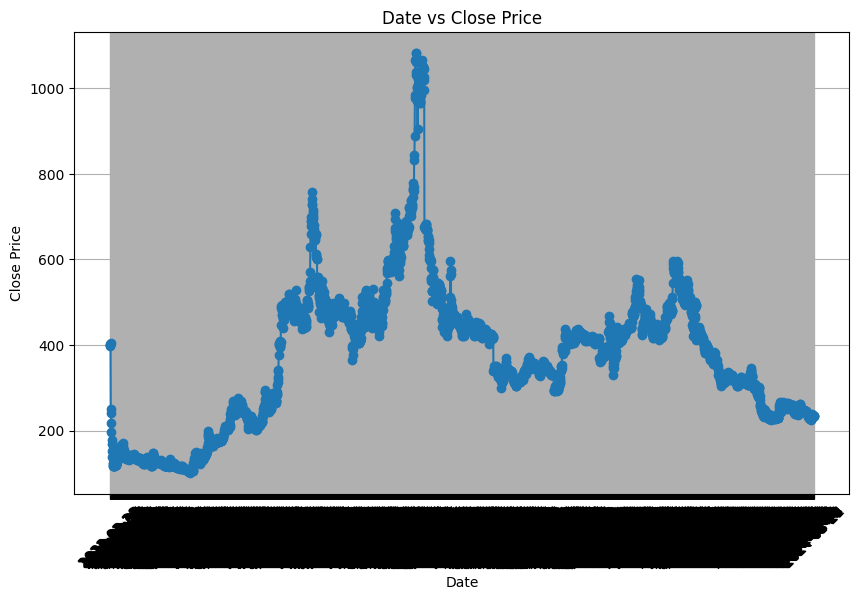

In [6]:
# print Date vs Close Price
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], marker='o', linestyle='-')
plt.title('Date vs Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid()

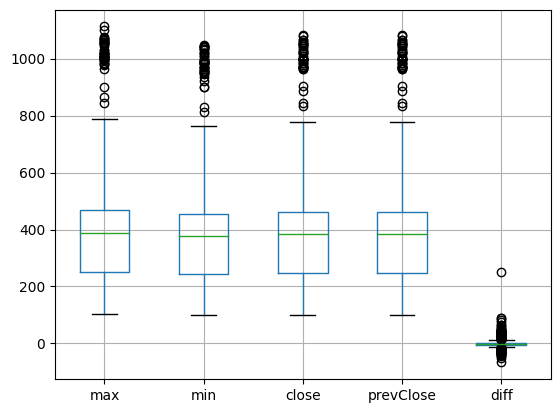

In [56]:
# Create box plot for the price details
df[['max', 'min', 'close', 'prevClose', 'diff']].boxplot()

plt.show()

In [2]:
df = get_stock_details('UPPER')
df.head()

,numTrans,tradedShares,amount,max,min,close,prevClose,diff,open
Date,,,,,,,,,
2022-02-20,991,133964,86429333,657.0,625.0,640.0,652.0,-12.0,NaN
2022-02-21,515,59236,38345090.4,652.0,640.0,650.0,640.0,10.0,NaN
2022-02-22,716,93051,60880264.5,660.0,646.0,649.0,650.0,-1.0,NaN
2022-02-23,604,73242,47813046.8,660.0,645.0,651.0,649.0,2.0,NaN
2022-02-24,987,136037,86912324.7,650.7,630.0,635.0,651.0,-16.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1189 entries, 2022-02-20 to 2024-04-02
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numTrans      1189 non-null   object 
 1   tradedShares  1189 non-null   object 
 2   amount        1189 non-null   object 
 3   max           1189 non-null   float64
 4   min           1189 non-null   float64
 5   close         1188 non-null   float64
 6   prevClose     1189 non-null   float64
 7   diff          1131 non-null   float64
 8   open          326 non-null    float64
dtypes: float64(6), object(3)
memory usage: 92.9+ KB


In [19]:
# make numTrans and tradedShares as float
df['numTrans'] = df['numTrans'].astype(float)
df['tradedShares'] = df['tradedShares'].astype(float)
df['amount'] = df['amount'].astype(float)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1189 entries, 2022-02-20 to 2024-04-02
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numTrans      1189 non-null   float64
 1   tradedShares  1189 non-null   float64
 2   amount        1189 non-null   float64
 3   max           1189 non-null   float64
 4   min           1189 non-null   float64
 5   close         1188 non-null   float64
 6   prevClose     1189 non-null   float64
 7   diff          1131 non-null   float64
 8   open          326 non-null    float64
dtypes: float64(9)
memory usage: 92.9+ KB


In [22]:
# Calculate statistical measures
stats = df.describe()

# Print statistical measures
print(stats)

           numTrans  tradedShares        amount          max          min  \
count   1189.000000  1.189000e+03  1.189000e+03  1189.000000  1189.000000   
mean     707.470984  9.817336e+04  5.086749e+07   421.903532   404.547014   
std      882.042684  1.414640e+05  8.370149e+07   197.675760   186.928399   
min        2.000000  3.000000e+01  6.470000e+03   173.000000   169.000000   
25%      235.000000  2.711300e+04  7.691906e+06   241.000000   234.000000   
50%      425.000000  5.338900e+04  1.959251e+07   395.400000   379.400000   
75%      844.000000  1.154740e+05  5.664031e+07   540.600000   520.000000   
max    13485.000000  2.768765e+06  8.958935e+08   962.500000   893.000000   

             close    prevClose         diff        open  
count  1188.000000  1189.000000  1131.000000  326.000000  
mean    411.547727   411.610723     0.068037  339.964110  
std     190.989561   190.965474    14.251968  123.327465  
min     170.200000   171.500000   -59.000000  169.000000  
25%     237

In [ ]:
# prediction function
def predict_price(df):
    
    # make numTrans and tradedShares as float
    df['numTrans'] = df['numTrans'].astype(float)
    df['tradedShares'] = df['tradedShares'].astype(float)
    df['amount'] = df['amount'].astype(float)
    #Calculate statistical measures
    stats = df.describe()

    # Predict the next index based on the trend observed in the provided data
    last_close = df['close'].iloc[-1]
    mean_close = stats.loc['mean', 'close']
    mean_prev_close = stats.loc['mean', 'prevClose']
    next_index = last_close + (mean_close - mean_prev_close)
    #print("Predicted next index:", next_index)
    st.write("Predicted next index:", next_index)
    
    # Generate a comprehensive report for the next week
    predicted_dates = pd.date_range(start=pd.to_datetime(df.index[-1]) + pd.Timedelta(days=1), periods=1)

    predicted_data = []

    for date in predicted_dates:
        predicted_row = {
            'numTrans': stats.loc['mean', 'numTrans'],
            'tradedShares': stats.loc['mean', 'tradedShares'],
            'amount': stats.loc['mean', 'amount'],
            'max': last_close + (mean_close - stats.loc['mean', 'prevClose']),
            'min': last_close + (mean_prev_close - stats.loc['mean', 'close']),
            'close': last_close + (mean_close - mean_prev_close),
            'prevClose': last_close
        }
        predicted_data.append(predicted_row)
        

    predicted_df = pd.DataFrame(predicted_data, index=predicted_dates)

    st.write(predicted_df)

    
        

In [23]:
# Calculate statistical measures
stats = df.describe()

# Predict the next index based on the trend observed in the provided data
last_close = df['close'].iloc[-1]
mean_close = stats.loc['mean', 'close']
mean_prev_close = stats.loc['mean', 'prevClose']
next_index = last_close + (mean_close - mean_prev_close)
print("Predicted next index:", next_index)


Predicted next index: 170.1370039758391


In [29]:
# Generate a comprehensive report for the next week
predicted_dates = pd.date_range(start=pd.to_datetime(df.index[-1]) + pd.Timedelta(days=1), periods=1)
predicted_data = []


In [30]:
stats.loc['mean']

numTrans        7.074710e+02
tradedShares    9.817336e+04
amount          5.086749e+07
max             4.219035e+02
min             4.045470e+02
close           4.115477e+02
prevClose       4.116107e+02
diff            6.803714e-02
open            3.399641e+02
Name: mean, dtype: float64

In [31]:

for date in predicted_dates:
    predicted_row = {
        'numTrans': stats.loc['mean', 'numTrans'],
        'tradedShares': stats.loc['mean', 'tradedShares'],
        'amount': stats.loc['mean', 'amount'],
        'max': last_close + (mean_close - stats.loc['mean', 'prevClose']),
        'min': last_close + (mean_prev_close - stats.loc['mean', 'close']),
        'close': last_close + (mean_close - mean_prev_close),
        'prevClose': last_close
    }
    predicted_data.append(predicted_row)


In [32]:

predicted_df = pd.DataFrame(predicted_data, index=predicted_dates)
print("\nPredicted Data for Next Week:")
print(predicted_df)



Predicted Data for Next Week:
              numTrans  tradedShares        amount         max         min  \
2024-04-03  707.470984  98173.359125  5.086749e+07  170.137004  170.262996   

                 close  prevClose  
2024-04-03  170.137004      170.2  


# index data

In [24]:
import pandas as pd
# Load data from the URL
url = "https://merolagani.com/Indices.aspx"
df_plot = pd.read_html(url)[0]
df_plot = df_plot.iloc[::-1].reset_index(drop=True)

df_plot.head()

,#,Date (AD),Index Value,Absolute Change,Percentage Change
0,100,2023/10/29,1875.65,-28.18,-1.48%
1,99,2023/10/30,1878.70,3.04,0.16%
2,98,2023/10/31,1864.40,-14.29,-0.76%
3,97,2023/11/01,1858.56,-5.83,-0.31%
4,96,2023/11/02,1847.70,-10.86,-0.58%


In [25]:
df_plot['Date (AD)'] = pd.to_datetime(df_plot['Date (AD)'])

# create the row of Open, High, Low, Close
df_plot['Open'] = df_plot['Index Value'] - df_plot['Absolute Change']
df_plot['High'] = df_plot['Index Value'] + df_plot['Absolute Change']


In [26]:
df_plot.head()

,#,Date (AD),Index Value,Absolute Change,Percentage Change,Open,High
0,100,2023-10-29,1875.65,-28.18,-1.48%,1903.83,1847.47
1,99,2023-10-30,1878.70,3.04,0.16%,1875.66,1881.74
2,98,2023-10-31,1864.40,-14.29,-0.76%,1878.69,1850.11
3,97,2023-11-01,1858.56,-5.83,-0.31%,1864.39,1852.73
4,96,2023-11-02,1847.70,-10.86,-0.58%,1858.56,1836.84


In [27]:
df_plot.columns

Index(['#', 'Date (AD)', 'Index Value', 'Absolute Change', 'Percentage Change',
       'Open', 'High'],
      dtype='object')

In [28]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   #                  100 non-null    int64         
 1   Date (AD)          100 non-null    datetime64[ns]
 2   Index Value        100 non-null    float64       
 3   Absolute Change    100 non-null    float64       
 4   Percentage Change  100 non-null    object        
 5   Open               100 non-null    float64       
 6   High               100 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.6+ KB


In [36]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

fig = go.Figure(data=[go.Candlestick(x=df_plot['Date (AD)'],
                open=df_plot['Open'],
                high=df_plot['High'],
                low=df_plot['Open'],
                close=df_plot['Index Value'])])
# plot moving average
fig.add_trace(go.Scatter(x=df_plot['Date (AD)'], y=df_plot['Index Value'].rolling(window=10).mean(), mode='lines', name='Moving Average 5 Days'))

fig.show()